# Estudo do Uso de Visual Transformers (ViT) Aplicado a Busca Reversa de Imagens

Aluna: Sandy Hoffmann

Disciplina: Inteligência Artificial Conexionista

Encontrar informações na internet de maneira rápida e precisa vêm se tornando um
desafio, devido ao excesso de conteúdo disponível. Uma das formas de pesquisa é a busca reversa de imagens (RIS - Reverse Image Search), no qual, dada uma imagem, deve-se retornar a imagem original, e suas variações. Essas variações, são a mesma imagem, porém com alterações visuais, tais quais, desfoque gaussiano, dessaturação, rotação, etc.

O dataset utilizado para o experimento é o "Butterfly & Moths Image Classification 100 species", utilizando uma imagem de cada espécie, totalizando 100 imagens diferentes - Link para download: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species/data.

Como queremos explorar o comportamento da busca com diferentes alterações visuais, alteramos as imagens de forma a explorar 8 aspectos visuais:

- Desfoque Gaussiano
- Dessaturação (Preto e Branco)
- Redução de resolução (128x128)
- Realce de nitidez
- Rotação (90° em sentido anti-horário)
- Espelhamento (horizontal)
- Corte (canto inferior direito 112x112x3)
- Inserção de elemento gráfico em ponto aleatório da figura.

Assim, no total temos 4500 figuras para a analise.

Descomente o código abaixo depois de ter baixado as imagens em uma pasta "original_images" para gerar as imagens modificadas.

In [65]:
# from variacoes_imagens import gera_imagens_similares_experimento

# gera_imagens_similares_experimento(
#     r"original_images", 
#     r"images"
# )

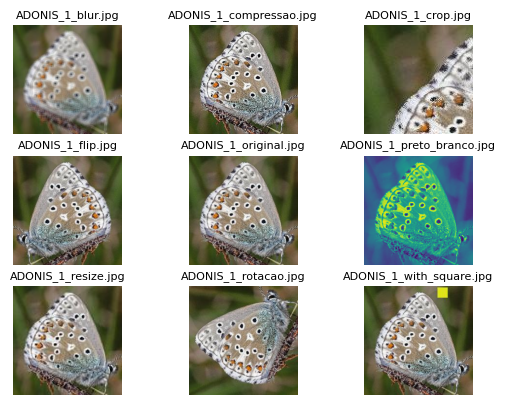

In [66]:
import os
import matplotlib.pyplot as plt

image_folder = './images'
lista_imgs = os.listdir(image_folder)

#plot 9 first images in a 3x3 grid

for i in range(9):
    img_path = os.path.join(image_folder, lista_imgs[i])
    img = plt.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(lista_imgs[i], fontsize=8)
plt.show()

## Configurando CNN

Utilizaremos o modelo VGG16 para este experimento.

In [67]:
import os
import numpy as np
from PIL import Image
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
import matplotlib.pyplot as plt
import faiss
from tqdm import tqdm

In [68]:
image_folder_cnn = './images'
feature_folder_cnn = './features'

base_model_cnn = VGG16(weights='imagenet')
model_cnn = Model(inputs=base_model_cnn.input, outputs=base_model_cnn.get_layer('fc1').output)

Para as entradas na rede VGG16, é necessário um pré-processamento, de modo a acertar a dimensão das imagens para 224x224.

In [69]:
def preprocess_image_cnn(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

O funcionamento da busca ocorrerá por meio dos vetores de peso do primeiro layer interamente conectado (fc1). Para que a busca não se torne demorada toda vez, geramos as features a salvamos em uma pasta, por meio de estruturas do numpy .npy. Assim, para buscar depois é só carregar os vetores do diretório.

In [70]:
def extract_and_save_features(image_folder, feature_folder):
    if not os.path.exists(feature_folder):
        os.makedirs(feature_folder)

    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) 
                  if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    print(f"Processing {len(image_paths)} images...")
    for img_path in tqdm(image_paths):
        img_array = preprocess_image_cnn(img_path)
        features = model_cnn.predict(img_array).flatten()  # Flatten the features
        feature_path = os.path.join(feature_folder, os.path.splitext(os.path.basename(img_path))[0] + '.npy')
        np.save(feature_path, features)


Apenas gere uma vez.

In [71]:
# extract_and_save_features(image_folder_cnn, feature_folder_cnn)

Para o mecânismo de busca, em ambos os casos, utilizaremos o faiss, que é uma biblioteca para busca de similaridade e agrupamento em vetores - https://faiss-ai.translate.goog/?_x_tr_sl=en&_x_tr_tl=pt&_x_tr_hl=pt&_x_tr_pto=tc.

In [72]:
def load_features_and_create_index_cnn(feature_folder):
    features = []
    file_names = []
    
    print("Loading features and creating FAISS index...")
    for feature_file in tqdm(os.listdir(feature_folder)):
        feature_path = os.path.join(feature_folder, feature_file)
        feature = np.load(feature_path)
        features.append(feature)
        file_names.append(os.path.splitext(feature_file)[0] + '.jpg')  # Normalize to .jpg
    
    features = np.vstack(features).astype('float32')
    
    # Create FAISS index
    dimension = features.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(features)
    
    return index, features, file_names

Inicializando index CNN:

In [73]:
index_faiss_cnn, features_cnn, file_names_cnn = load_features_and_create_index_cnn(feature_folder_cnn)


Loading features and creating FAISS index...


100%|██████████| 4500/4500 [00:04<00:00, 961.74it/s] 


Para pesquisar as imagens similares, faremos da seguinte forma:

In [74]:
def search_similar_images_cnn(query_image_path, index, file_names, k=9):
    feature = features_cnn[file_names.index(os.path.basename(query_image_path))]
    query_features = np.array([feature], dtype='float32')
    distances, indices = index.search(query_features, k)
    
    results = []
    for i, idx in enumerate(indices[0]):
        results.append({
            'image_path': file_names[idx],
            'distance': distances[0][i]
        })
    
    return results

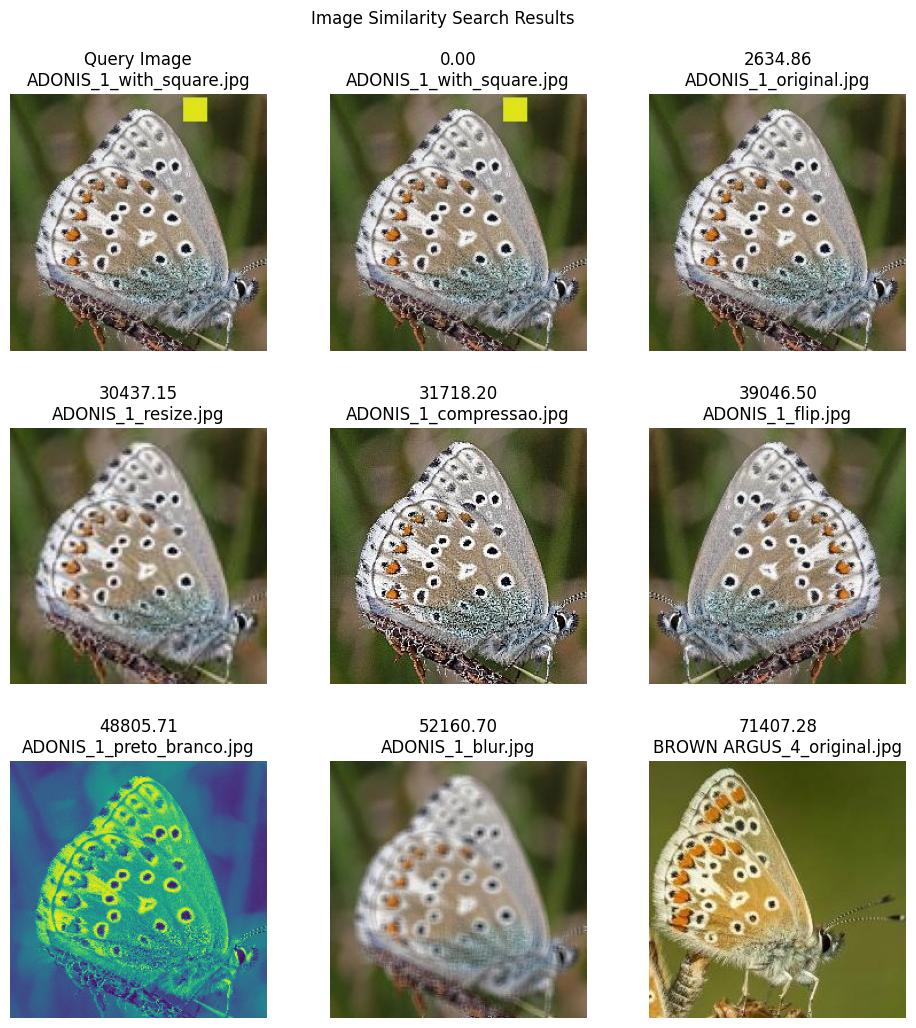

In [75]:
query_image_path = os.path.join(image_folder, lista_imgs[i])
resultados = search_similar_images_cnn(query_image_path, index_faiss_cnn, file_names_cnn, k=8)  

plt.figure(figsize=(12, 12)) 

query_img = plt.imread(query_image_path)
plt.subplot(3, 3, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title(f"Query Image\n{lista_imgs[i]}", fontsize=12)

for idx, resultado in enumerate(resultados):
    img_result = plt.imread(os.path.join(image_folder, resultado['image_path']))
    plt.subplot(3, 3, idx + 2) 
    plt.imshow(img_result)
    plt.axis('off')
    plt.title(f"{resultado['distance']:.2f}\n{resultado['image_path']}", fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.3)  
plt.suptitle(f"Image Similarity Search Results", y=0.95)
plt.show()

Calculo acurácia para o experimento das CNNs:

In [76]:
def experimento_efetividade_operacoes_imagens_cnn(index):
    lista_imagens = os.listdir(image_folder)
    num_img_avaliadas = 9
    query_img = file_names_cnn[index]
    query_path = os.path.join(image_folder, query_img)
    results = search_similar_images_cnn(lista_imagens[index], index_faiss_cnn, file_names_cnn, k=num_img_avaliadas)

    acc = 0
    loss = 0
    for i in range(num_img_avaliadas):
        nome_img = results[i]['image_path'].split("_")[0:2]
        nome_img = "_".join(nome_img)
        if nome_img in query_img:
            acc += 1
        else:
            loss += 1
    
    return {
        'accuracy': acc,
        'loss': loss
    }

## Configurando ViT

Para o ViT, utilizaremos as bibliotecas fornecidas pela "Hugging Face":
- ViTFeatureExtractor: pré-processa as imagens no formato esperado pelo modelo.
- ViTModel: contém a arquitetura do transformer pré-treinado que iremos utilizar.

O PyTorch será utilizado para aproveitar da aceleração de GPU.

In [77]:
from transformers import ViTFeatureExtractor, ViTModel
import torch 

O modelo escolhido para esse experimento foi o vit-base-patch16-224-in21k, que é pré-treinado no dataset ImageNet-21k (14 milhões de imagens, 21.843 classes) - https://huggingface.co/google/vit-base-patch16-224-in21k.

In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

model_name_vit = 'google/vit-base-patch16-224-in21k'
feature_extractor_vit = ViTFeatureExtractor.from_pretrained(model_name_vit)
model_vit = ViTModel.from_pretrained(model_name_vit).to(device)
model_vit.eval()

Usando dispositivo: cuda


c:\Python312\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [79]:
image_dir_vit = "./images"  
image_paths_vit = [os.path.join(image_dir_vit, f) for f in os.listdir(image_dir_vit) if f.endswith(('.jpg', '.png'))]
feature_dir_vit = "./features-vit"

Para representação, utilizaremos o token de classificação (CLS), extraindo do modelo e posteriormente salvando-o em arquivos .npy, de forma semelhante a CNN.

In [80]:
def get_image_embedding_vit(image_path):
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    
    inputs = feature_extractor_vit(images=image, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model_vit(**inputs)
    
    # Usamos o embedding do token [CLS] como representação da imagem
    embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embedding


Salvando as features (apenas necessário uma vez)

In [81]:
def extract_and_save_features_vit(image_folder, feature_folder):

    print(f"Processando {len(image_folder)} imagens...")
    for path in tqdm(image_folder):
        emb = get_image_embedding_vit(path)
        feature_path = os.path.join(feature_folder, os.path.splitext(os.path.basename(path))[0] + '.npy')
        np.save(feature_path, emb)
    print("Features extraídas e salvas.")


In [82]:
# extract_and_save_features_vit(image_paths_vit, feature_dir_vit)

Carregando features e alimentando mecanismo de busca Faiss:

In [83]:
def load_all_features_vit(feature_folder):
    features = []
    file_names = []
    for feature_file in os.listdir(feature_folder):
        feature_path = os.path.join(feature_folder, feature_file)
        feature = np.load(feature_path)
        features.append(feature)
        feature_file = os.path.splitext(feature_file)[0] + '.jpg'  
        file_names.append(feature_file)
    return np.vstack(features).astype('float32'), file_names


In [84]:
embeddings_vit, image_paths_vit = load_all_features_vit(feature_dir_vit)

dimension_vit = embeddings_vit.shape[1]
index_vit = faiss.IndexFlatL2(dimension_vit)
index_vit.add(embeddings_vit)

Função para buscar imagens similares - ViT:

In [85]:
def search_similar_images_vit(query_image_path, k=9):
    query_embedding = get_image_embedding_vit(query_image_path)
    
    # Buscar os k vizinhos mais próximos
    distances, indices = index_vit.search(query_embedding, k)
    
    # Retornar os resultados
    results = []
    for i, idx in enumerate(indices[0]):
        results.append({
            'image_path': image_paths_vit[idx],
            'distance': distances[0][i]
        })
    
    return results

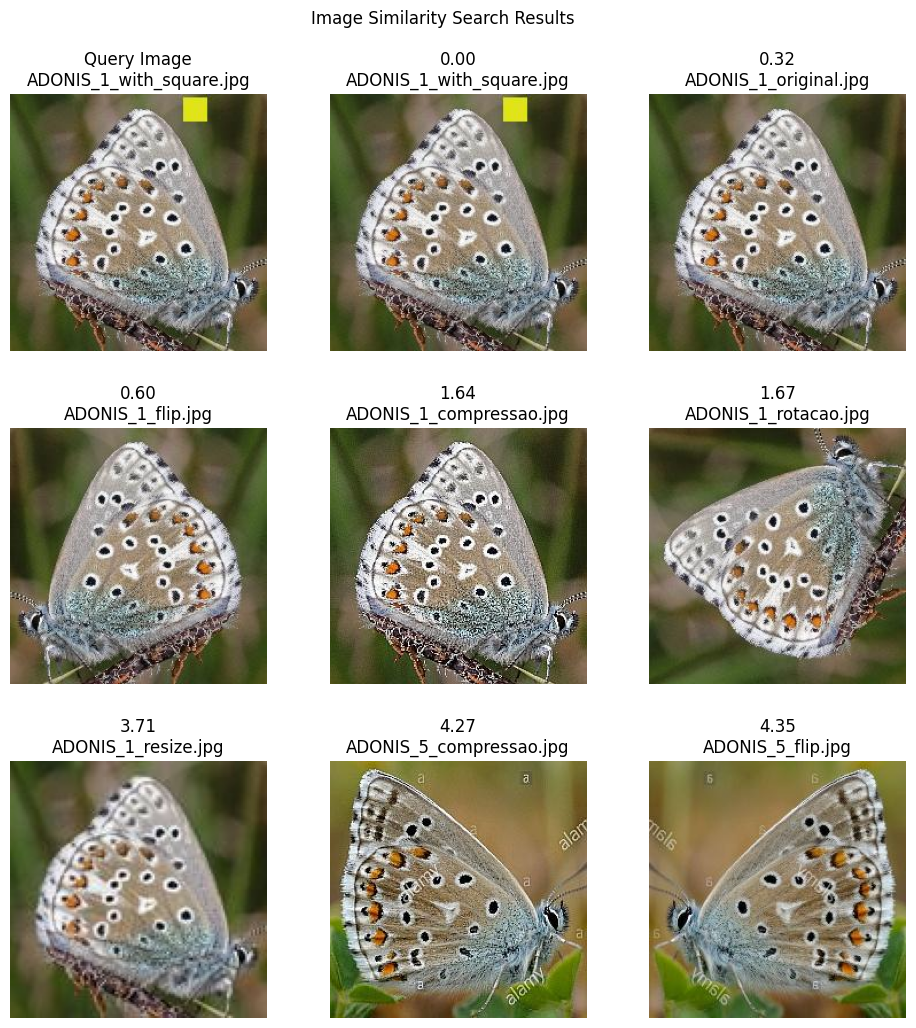

In [86]:
query_image_path = os.path.join(image_folder, lista_imgs[i])
resultados = search_similar_images_vit(query_image_path, k=8)  

plt.figure(figsize=(12, 12)) 

query_img = plt.imread(query_image_path)
plt.subplot(3, 3, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title(f"Query Image\n{lista_imgs[i]}", fontsize=12)

for idx, resultado in enumerate(resultados):
    img_result = plt.imread(os.path.join(image_folder, resultado['image_path']))
    plt.subplot(3, 3, idx + 2) 
    plt.imshow(img_result)
    plt.axis('off')
    plt.title(f"{resultado['distance']:.2f}\n{resultado['image_path']}", fontsize=12)

plt.subplots_adjust(wspace=0.1, hspace=0.3)  
plt.suptitle(f"Image Similarity Search Results", y=0.95)
plt.show()

Calculo acurácia para o experimento do ViT:

In [87]:
def experimento_efetividade_operacoes_imagens_vit(index):
    num_img_avaliadas = 9
    query_img = image_paths_vit[index]
    query_path = f'./images/{query_img}'
    results = search_similar_images_vit(query_path, k=num_img_avaliadas)

    acc = 0
    loss = 0
    for i in range(num_img_avaliadas):
        nome_img = results[i]['image_path'].split("_")[0:2]
        nome_img = "_".join(nome_img)
        if (nome_img in query_img):
            acc += 1
        else:
            loss += 1
    
    return {
        'accuracy': acc,
        'loss': loss
    }

## Experimento

Selecionamos um numero X de imagens aleatóriamente, e colocamos os dois modelos a prova. Depois comparamos sua acurácia. As configurações da quantidade e dos tipos avaliados podem ser alterados, sendo possível fazer isso alterando as variáveis abaixo.

In [92]:
import random

qtd_por_tipo = 100
tipos_disponiveis = ['original', 'blur', 'preto_branco', 'resize' , 'compressao', 'rotacao', 'flip', 'crop', 'with_square']
label_tipos_disponiveis = ['Original', 'Blur\n Gaussiano', 'Preto\n e Branco', 'Mudança\n de Tamanho' , 'Realce\n de nitidez', 'Rotação\n (90%)', 'Espelhar', 'Corte', 'Com\n elemento\n quadrado']

dict_resultados_cnn = {}
dict_resultados_vit = {}
lista_imagens_sorteadas = {}

lista_imagens = os.listdir("./images")

for tipo in tipos_disponiveis:
    for i in range(qtd_por_tipo):
        imagens_disponiveis = list(filter(lambda nome: tipo in nome, lista_imagens))
        random_index_img_disponivel = random.randint(0, len(imagens_disponiveis) - 1)	

        random_index = lista_imagens.index(imagens_disponiveis[random_index_img_disponivel])
        if not lista_imagens_sorteadas.get(tipo):
            lista_imagens_sorteadas[tipo] = []
        lista_imagens_sorteadas[tipo].append(random_index)

Testando acurácia CNN:

In [93]:
for (tipo, label) in zip(tipos_disponiveis, label_tipos_disponiveis):
    dict_resultados_cnn[label] = {"accuracy": 0, "loss": 0}
    for i in range(qtd_por_tipo):
        resultados = experimento_efetividade_operacoes_imagens_cnn(lista_imagens_sorteadas[tipo][i])
        dict_resultados_cnn[label]['accuracy'] += resultados['accuracy']
        dict_resultados_cnn[label]['loss'] += resultados['loss']
print(f'CNN: {dict_resultados_cnn}')


CNN: {'Original': {'accuracy': 735, 'loss': 165}, 'Blur\n Gaussiano': {'accuracy': 420, 'loss': 480}, 'Preto\n e Branco': {'accuracy': 421, 'loss': 479}, 'Mudança\n de Tamanho': {'accuracy': 678, 'loss': 222}, 'Realce\n de nitidez': {'accuracy': 719, 'loss': 181}, 'Rotação\n (90%)': {'accuracy': 481, 'loss': 419}, 'Espelhar': {'accuracy': 721, 'loss': 179}, 'Corte': {'accuracy': 160, 'loss': 740}, 'Com\n elemento\n quadrado': {'accuracy': 724, 'loss': 176}}


Testando acurácia ViT:

In [94]:
for (tipo, label) in zip(tipos_disponiveis, label_tipos_disponiveis):
    dict_resultados_vit[label] = {"accuracy": 0, "loss": 0}
    for i in range(qtd_por_tipo):
        resultados = experimento_efetividade_operacoes_imagens_vit(lista_imagens_sorteadas[tipo][i])
        dict_resultados_vit[label]['accuracy'] += resultados['accuracy']
        dict_resultados_vit[label]['loss'] += resultados['loss']
print(f'VIT: {dict_resultados_vit}')

VIT: {'Original': {'accuracy': 714, 'loss': 186}, 'Blur\n Gaussiano': {'accuracy': 691, 'loss': 209}, 'Preto\n e Branco': {'accuracy': 299, 'loss': 601}, 'Mudança\n de Tamanho': {'accuracy': 692, 'loss': 208}, 'Realce\n de nitidez': {'accuracy': 698, 'loss': 202}, 'Rotação\n (90%)': {'accuracy': 689, 'loss': 211}, 'Espelhar': {'accuracy': 721, 'loss': 179}, 'Corte': {'accuracy': 500, 'loss': 400}, 'Com\n elemento\n quadrado': {'accuracy': 704, 'loss': 196}}


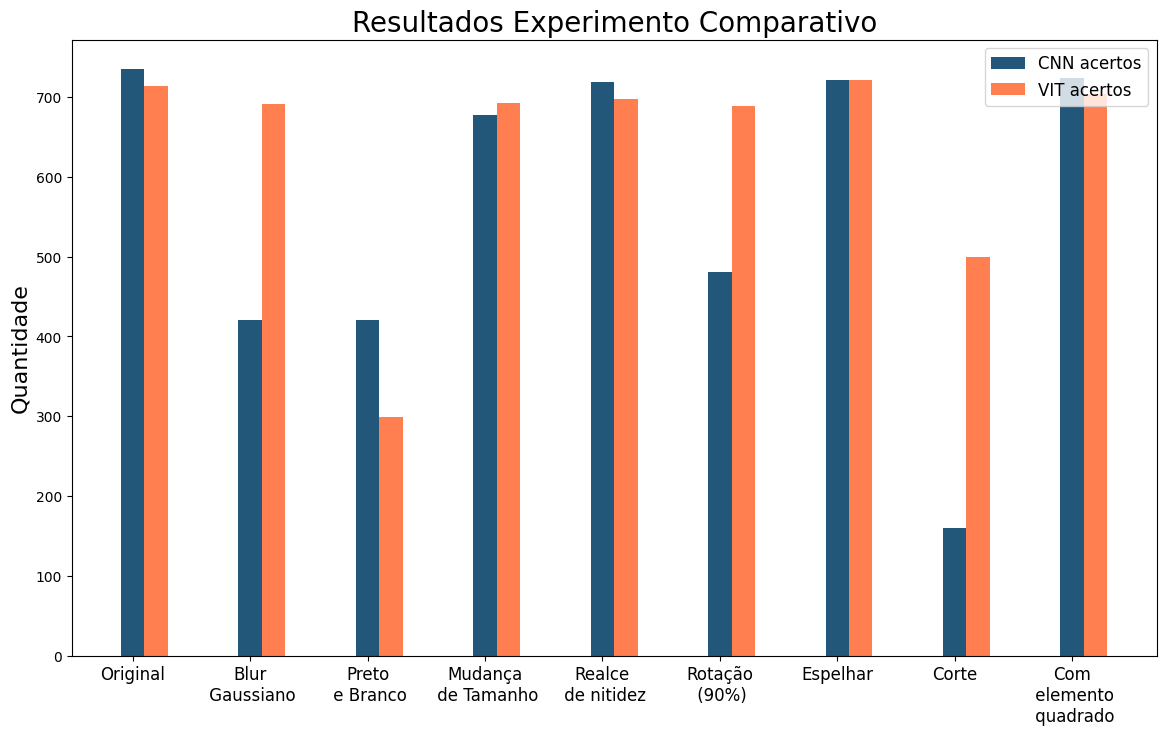

In [96]:

fig, ax = plt.subplots(figsize=(14, 8))


labels = list(dict_resultados_cnn.keys())

colors = ["#22577a", "#ff7f50"]

accuracy_cnn = [dict_resultados_cnn[group]['accuracy']  for group in labels]
accuracy_vit = [dict_resultados_vit[group]['accuracy'] for group in labels]

x = np.arange(len(labels))  # the label locations
width = 0.2  # the width of the bars

ax.bar(x, accuracy_cnn, width, label='CNN acertos', color=colors[0])
ax.bar(x + width, accuracy_vit, width, label='VIT acertos', color=colors[1])
ax.legend(fontsize=12)

ax.set_ylabel('Quantidade', fontsize=16)
ax.set_title('Resultados Experimento Comparativo', fontsize=20)
ax.set_xticks(x, labels,  fontsize=12)

plt.show()


## Conclusão

Podemos ver que ambos os modelos conseguiram resultados próximos nas operações de busca em imagens sem alterações, mudança de tamanho, realce de nitidez, espelhamento e inserção de elemento gráfico. 

A CNN conseguiu uma margem considerável a mais que o ViT no caso de imagens em preto e branco, o que pode apontar que a CNN consegue manter a extração de padrões mesmo quando a imagem perde detalhes ou cores.

Em operações de blur gaussiano, rotação e corte, o ViT possuiu uma margem a mais que a CNN, o que pode ser justificado por sua arquitetura de atenção, que mantém a relação entre os patches das imagens, de forma global, tornando o modelo menos sensível a rotações e alterações na figura.

Assim, dentro desse experimento, o ViT conseguiu melhor desempenho em um número maior de categorias se comparado a CNN. Para diversificar esse experimento, sugere-se futuramente testar com diferentes tipos de CNN, treinadas com datasets maiores. Também há planos para tornar o dataset do experimento mais diversificado (ao invés de apenas focar em uma classe de objetos - borboletas), em maior escala, e com mais operações visuais.
